In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [5]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement_Table = Base.classes.measurement
Station_Table = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
##Find columns name in measurement
Measurement_column_names = session.query(Measurement_Table)
print(Measurement_column_names)

SELECT measurement.id AS measurement_id, measurement.station AS measurement_station, measurement.date AS measurement_date, measurement.prcp AS measurement_prcp, measurement.tobs AS measurement_tobs 
FROM measurement


In [10]:
# Find the most recent date in the data set.
Recent_date = session.query(func.max(Measurement_Table.date)).first()[0]
print(Recent_date)

2017-08-23


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
Recent_Data_DB = dt.datetime.strptime(Recent_date, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
OneYearEarlier = Recent_Data_DB - dt.timedelta(days=365)
OneYearEarlier_DB = dt.datetime.strftime(OneYearEarlier,"%Y-%m-%d")
print(OneYearEarlier_DB)

2016-08-23


In [12]:
# Perform a query to retrieve the data and precipitation scores
PrecipitationScore = session.query(Measurement_Table.date, Measurement_Table.prcp)\
                    .filter(Measurement_Table.date <= Recent_Data_DB)\
                    .filter(Measurement_Table.date >= OneYearEarlier_DB).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
PrecipitationScoreData = pd.DataFrame(PrecipitationScore, columns=["date", "precipitation"])
PrecipitationScoreData = PrecipitationScoreData.set_index("date")
PrecipitationScoreData.head()


,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [13]:
# Sort the dataframe by date
PrecipitationScoreData = PrecipitationScoreData.sort_values(by=["date"])
PrecipitationScoreData.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


In [14]:
PrecipitationScoreData = PrecipitationScoreData.dropna()
PrecipitationScoreData.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


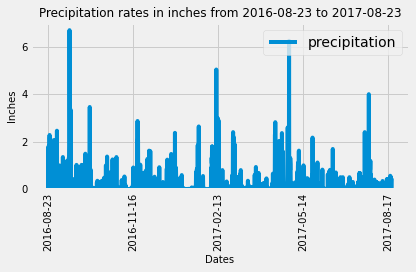

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data 
PrecipitationScoreData.plot(rot = 90, fontsize = 10)
plt.ylabel("Inches", fontsize = 10)
plt.xlabel("Dates", fontsize = 10)
plt.title(f"Precipitation rates in inches from {OneYearEarlier_DB} to {Recent_date}", fontsize = 12)
plt.ylim(0, max(PrecipitationScoreData["precipitation"])+.3)
plt.tight_layout()
plt.savefig("Output/Precipitation_Score_Data.png")

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
PrecipitationScoreData.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
##Find columns name in station
Station_column_names = session.query(Station_Table)
print(Station_column_names)

SELECT station.id AS station_id, station.station AS station_station, station.name AS station_name, station.latitude AS station_latitude, station.longitude AS station_longitude, station.elevation AS station_elevation 
FROM station


In [18]:
# Design a query to calculate the total number stations in the dataset
Total_Stations = session.query(Station_Table).group_by(Station_Table.station).count()
Total_Stations

9

In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
MostActiveStation = session.query(Measurement_Table.station, func.count(Measurement_Table.id)).group_by(Measurement_Table.station).order_by(func.count(Measurement_Table.id).desc()).all()
MostActiveStation

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
MostActiveStationData = session.query(func.min(Measurement_Table.tobs), func.max(Measurement_Table.tobs), func.avg(Measurement_Table.tobs)).filter(Measurement_Table.station == "USC00519281").all()
print(f"The Lowest Temperature of {MostActiveStation[0][0]} is {MostActiveStationData[0][0]}")
print(f"The Highest Temperature of {MostActiveStation[0][0]} is {MostActiveStationData[0][1]}")
print(f"The Average Temperature of {MostActiveStation[0][0]} is {MostActiveStationData[0][2]}")

The Lowest Temperature of USC00519281 is 54.0
The Highest Temperature of USC00519281 is 85.0
The Average Temperature of USC00519281 is 71.66378066378067


In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
ActiveStationData_12Months = session.query(Measurement_Table.tobs).filter(Measurement_Table.date <= Recent_Data_DB).filter(Measurement_Table.date >= OneYearEarlier_DB).filter(Measurement_Table.station == MostActiveStation[0][0]).all()
ActiveStationData_12Months_DF = pd.DataFrame(ActiveStationData_12Months, columns=["tobs"])
ActiveStationData_12Months_DF


,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


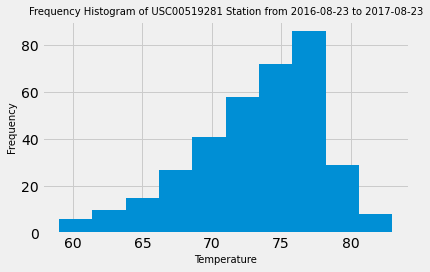

In [22]:
# plot the results as a histogram
plt.hist(ActiveStationData_12Months_DF["tobs"], label = "tobs")
plt.xlabel("Temperature",fontsize = 10)
plt.ylabel("Frequency", fontsize = 10)
plt.title(f"Frequency Histogram of {MostActiveStation[0][0]} Station from {OneYearEarlier_DB} to {Recent_date}", fontsize = 10)
plt.tight_layout()
plt.savefig("Output/Histogram_ActiveStation_Temperature.png")
plt.show()

# Close session

In [23]:
# Close Session
session.close()